tensor([[[100., 104., 105.,  ..., 115., 132., 142.],
         [ 95., 106., 109.,  ..., 122., 132., 137.],
         [ 92., 101., 104.,  ..., 125., 121., 122.],
         ...,
         [152., 164., 171.,  ..., 168., 159., 146.],
         [145., 154., 155.,  ..., 161., 155., 147.],
         [150., 154., 152.,  ..., 162., 158., 156.]]])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
tensor([0, 2])


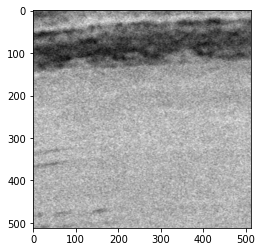

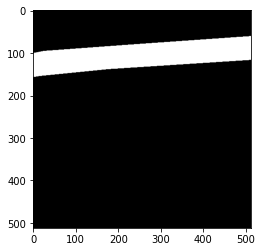

finished


In [1]:
from unet import *
from segmentation_dataset import *
from load_data import *

In [2]:

#dataloader code

import os
from torch.utils.data import DataLoader
from segmentation_dataset import SegmentationDataset
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import datasets, transforms

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

train_path = "small_dataset/images/nir/"
val_path = "small_dataset/images/nir/"
train_labels_path = "small_dataset/labels/"

train_img_names_index = os.listdir(train_path)
val_img_names_index = os.listdir(val_path)

labels_one_hot = {}
k = 9
for i, label in enumerate(listdir_nohidden(train_labels_path)):
    labels_one_hot[label] = np.zeros((k,))
    labels_one_hot[label][i] = 1

train_dataset = SegmentationDataset(train_img_names_index, labels_one_hot)
val_dataset = SegmentationDataset(val_img_names_index, labels_one_hot)
 
batch_size = 1
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


print("finished")

finished


In [15]:
#SETTINGS
Use_GPU = True
Lr = 0.01
channels = 1 # 512*512 #pixels
classes = 10 #outputs 
maxEpochs = 1
batch_size = 2
shuffle = True

#Code 
if Use_GPU: 
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')
#initalize model 

#fix activationfunc, dropout and other settings for model as parameters later 

model = UNet(channels,classes).to(device)

#two different filepaths
pathTrain = "Agriculture-Vision-2021\train"
pathVal = "Agriculture-Vision-2021\val"

trainValRate = 0.7 #not in use
lrRatesplan = None #not in use
activation = "relu" #not in use 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), Lr)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

# trainY = SegmentationDataset(train_img_names_index, labels_one_hot)
# validateY = SegmentationDataset(train_img_names_index, labels_one_hot)


In [16]:
#trainer class/object?

from tqdm import tqdm, trange

trainingLoss = []
validationLoss = []
validate_go = False  # True

def itterProgress(x, text = "training"):
    return tqdm(enumerate(x), text, total = len(x))

def run(): 
    # itter = itterProgress(trainX)
    
    
    for epoch in range(maxEpochs):
        train()
        if epoch % 10 == 0: 
            print("training Epoch :" + str(epoch)  + "max Epochs")
        
        if validate_go: 
            validate()

    print(trainingLoss)
    print('training done')
    print(validationLoss)
    

def train(): 
    
    model.train()
    
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        print(i)
        indata, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        print(target.shape)
        
        indata = indata.unsqueeze(1)

        out = model(indata)
        print(out.shape)
        # out = model(indata[None, ...])
        loss = criterion(out, target)
        loss_value = loss.item()

        trainingLoss.append(loss_value)

        loss.backward()
        optimizer.step()
        
def validate(): 
    
    model.eval()
    
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        
        with torch.no_grad():

            indata = indata.unsqueeze(1)

            out = model.forward(indata)
            # out = model(indata[None, ...])
            loss = criterion(out, target)
            loss_value = loss.item()

            validationLoss.append(loss_value)

run()


0
torch.Size([2, 512, 512])
torch.Size([2, 9, 512, 512])
1
torch.Size([2, 512, 512])
torch.Size([2, 9, 512, 512])
2
torch.Size([2, 512, 512])
torch.Size([2, 9, 512, 512])
3
torch.Size([2, 512, 512])
torch.Size([2, 9, 512, 512])
4
torch.Size([2, 512, 512])
torch.Size([2, 9, 512, 512])
training Epoch :0max Epochs
[2.5317013263702393, 5.647232532501221, 17.977617263793945, 2.1728994846343994, 2.3594346046447754]
training done
[]
